<a href="https://colab.research.google.com/github/evillag/uncertainty_gan/blob/main/TestBench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
IN_COLAB = True

try:
  import google.colab
  # Using Google Drive
  from google.colab import drive
  drive.mount('/content/drive')

  !git clone https://github.com/evillag/uncertainty_gan.git
  !mv uncertainty_gan/mcd .
  !mv uncertainty_gan/feature_densities .
  !mv uncertainty_gan/test_bench .
  %rm -rf uncertainty_gan/

  !git clone https://gitlab.com/lambda-hse/lhcb-rich-gan-uncertainty.git
  !mv lhcb-rich-gan-uncertainty/experiments .
  !mv lhcb-rich-gan-uncertainty/src .
  %rm -rf lhcb-rich-gan-uncertainty/
  %rm -rf sample_data/
  %pip install tensorflow-addons

  # Dataset download and extraction
  !unzip -qq drive/MyDrive/cern/data/rich.zip

  # Model checkpoint download and extraction
  !unzip -qq drive/MyDrive/cern/data/checkpoints_dropout_0.01.zip

  # Model embeddings download and extraction
  !unzip -qq drive/MyDrive/cern/data/embeddings.zip

  # Results folder creation
  !mkdir /content/drive/MyDrive/cern/data/results

except:
  IN_COLAB = False

print(f'IN_COLAB: {IN_COLAB}')

Mounted at /content/drive
Cloning into 'uncertainty_gan'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 168 (delta 9), reused 4 (delta 3), pack-reused 147
Receiving objects: 100% (168/168), 19.08 MiB | 18.13 MiB/s, done.
Resolving deltas: 100% (85/85), done.
Cloning into 'lhcb-rich-gan-uncertainty'...
remote: Enumerating objects: 210, done.
remote: Total 210 (delta 0), reused 0 (delta 0), pack-reused 210 (from 1)
Receiving objects: 100% (210/210), 2.94 MiB | 10.87 MiB/s, done.
Resolving deltas: 100% (94/94), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.4 MB/s eta 0:00:00
mkdir: cannot create directory ‘/content/drive/MyDrive/cern/data/results’: File exists
IN_COLAB: True


In [2]:
import matplotlib.pyplot as plt
import numpy as np

from test_bench import get_checkpoint_name, load_particle_datasets, subsample_dataset
from test_bench.model import MonteCarloDropoutModel


# Test Bench for the Monte Carlo Dropout and Feature Density methods

1. Select sample data
2. Create a model
3. Generate a single target with single inference mode
4. Estimate MCD uncertainty
5. Estimate FD uncertainty

In [3]:
# Parameters
PARTICLE = 'pion'
CHECKPOINT_DP = 0.01
DROPOUT_TYPE = 'bernoulli_structured'
CHECKPOINT_BASE = 'checkpoints/'
DATA_DIR = 'rich/'
SUB_SAMPLE_SIZE = 100000
DLL_COLUMNS = ['RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLbt']

# MCD parameters
MCD_ENSEMBLE_SIZE = 300

# FD parameters
embeddings_dir = f'embeddings/'

# Save results path
output_dir = 'results/'
if IN_COLAB:
  output_dir = f'/content/drive/MyDrive/cern/data/{output_dir}'

# Load data and Sample selection

In [4]:
dataset = load_particle_datasets(PARTICLE, DATA_DIR)

Reading and concatenating datasets:
	rich/pion_+_up_2016_.csv
	rich/pion2_+_down_2016_.csv
	rich/pion2_-_down_2016_.csv
	rich/pion_+_down_2016_.csv
	rich/pion_-_down_2016_.csv
	rich/pion2_+_up_2016_.csv
	rich/pion_-_up_2016_.csv
	rich/pion2_-_up_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 3.8427252769470215
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>
feats_train shape	(948274, 3)
targets_train shape	(948274, 5)
feats_val shape  	(524637, 3)
targets_val shape	(524637, 5)



In [5]:
# Draw a sample of the datasets
x_sample, y_sample = subsample_dataset(dataset['feats_val'], dataset['targets_val'], SUB_SAMPLE_SIZE / dataset['feats_val'].shape[0])
x_sample.shape, y_sample.shape

(TensorShape([100000, 3]), TensorShape([100000, 5]))

# Model creation

In [6]:
model = MonteCarloDropoutModel(
    PARTICLE,
    dropout_rate=CHECKPOINT_DP,
    checkpoint_dir=CHECKPOINT_BASE + get_checkpoint_name(PARTICLE, CHECKPOINT_DP, DROPOUT_TYPE),
    debug=True
)
generator = model.get_generator()

Generating model for pion with a dropout rate of 0.01
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4

Generator:

Model: "virtual_ensemble_model"
________________________________________________________________________________________________
 Layer (type)                              Output Shape                          Param #        
 Inputs (InputLayer)                       [(None, 3)]                           0              
                                                                                                
 NoiseInjection (NoiseInjection)           (None, 67)                            0              
                                                                                                
 Layer_0/Dense (Dense)                     (None, 128)                           8704           
                                                                                                
 Layer_0/LeakyReLU (LeakyReLU)             (None, 128)                           0   

## Single model prediction

In [7]:
generator.single_model_inference_mode()
t_generated = generator.predict(x_sample)
t_generated

3125/3125 [==============================] - 24s 5ms/step


array([[ 0.5479358 , -0.6812682 ,  0.51924026, -0.20748997, -0.2549283 ],
       [ 0.02918948, -1.3565044 , -0.18756591, -1.2514749 , -0.68379796],
       [-2.044814  , -0.61185306, -2.4552207 , -0.5098161 , -0.54255456],
       ...,
       [-0.88859314, -1.4549372 , -0.43555894, -1.2106698 , -1.3117061 ],
       [-0.1849823 , -2.3708982 ,  0.13369258, -2.005506  , -2.190477  ],
       [ 1.5194682 , -1.9485664 ,  1.7642856 , -1.8147666 , -2.06587   ]],
      dtype=float32)

In [8]:
# Save real and generated targets
np.save(output_dir + f'{PARTICLE}_t_generated.npy', t_generated)
np.save(output_dir + f'{PARTICLE}_y_real.npy', y_sample)

### Plotting functions

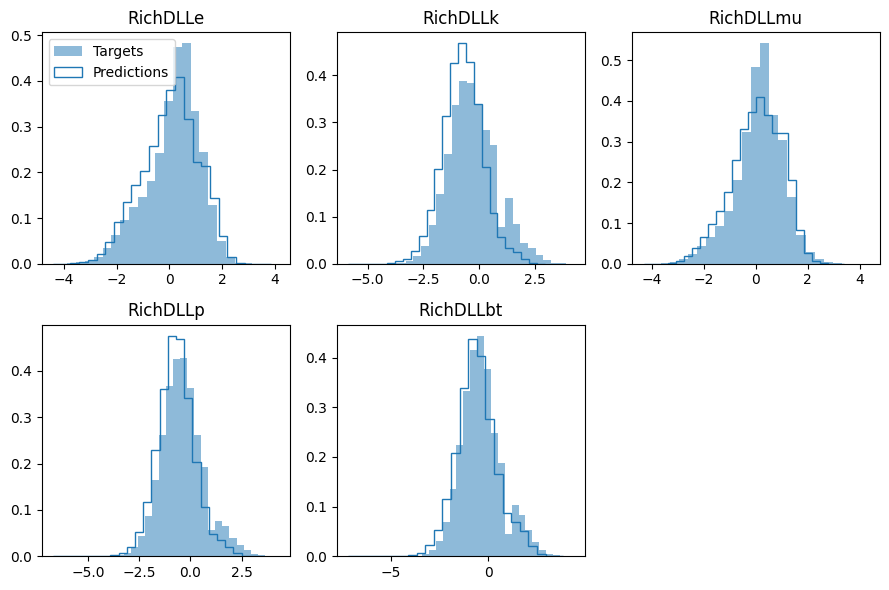

In [9]:
def plot_target_histrogams(real_target, generated_targets, dll_columns=DLL_COLUMNS):
  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    particle_targets = np.array(real_target[:, i])
    particle_predictions = np.array(generated_targets[:, i])

    ax.set_title(dll_columns[i])
    ax.hist(particle_targets, 25, None, True, alpha=.5, label='Targets')
    ax.hist(particle_predictions, 25, None, True, histtype='step', color='tab:blue', label='Predictions')

  axes[0, 0].legend()
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

plot_target_histrogams(y_sample, t_generated)

In [26]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import linregress

def estimate_distances_and_plot_uncertainty_bins(y_real, y_generated, uncertainty_scores, uncertainty_type = None,
                                                 particle_index = 0, n_rows = 3, n_cols = 3, dll_columns=DLL_COLUMNS):
  n_rows, n_cols = 3, 3
  n_bins = n_rows * n_cols

  particle_index = 0

  targets = np.array(y_real[:, particle_index])
  predictions = np.array(y_generated[:, particle_index])
  uncertainty_scores = np.array(uncertainty_scores)

  if uncertainty_type == 'MCD':
    uncertainty_scores = uncertainty_scores[:, particle_index]

  bin_edges = np.linspace(uncertainty_scores.min(), uncertainty_scores.max(), n_bins + 1)

  # Digitize returns sample indices per bin
  bin_indices = np.digitize(uncertainty_scores, bin_edges)

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

  rounded_bin_edges = np.round(bin_edges, 2)

  js_distances = []

  for i, ax in zip(range(n_bins), axes.flatten()):
    indices = bin_indices == i + 1

    hist_range = targets[indices].min(), targets[indices].max()

    targets_hist = ax.hist(targets[indices], 25, hist_range, True, alpha=.5, label='Targets')[0]
    predictions_hist = ax.hist(
        predictions[indices], 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')[0]

    ax.set_xlabel(f'{rounded_bin_edges[i]} < unc. score < {rounded_bin_edges[i + 1]}', bbox={'facecolor': 'none'})

    js_dist = jensenshannon(predictions_hist, targets_hist)
    print('Jensen–Shannon divergence:', js_dist)
    js_distances += [js_dist]

  plt.suptitle(dll_columns[particle_index])
  axes[0, 0].legend()
  plt.tight_layout()
  plt.show()
  return bin_edges, js_distances


def plot_distances(bin_ranges, distances, dll_columns=DLL_COLUMNS, particle_index = 0):
  plt.title(dll_columns[particle_index])
  plt.plot(bin_ranges[:-1], distances, '.-')
  plt.xlabel('Uncertainty score')
  plt.ylabel('JS distance')
  plt.show()

  print('Correlation coefficient:', linregress(bin_ranges[:-1], distances).rvalue)


## Monte Carlo Dropout method

In [10]:
from mcd.MCDEvaluator import evaluate_model as mcd_evaluate_model

mcd_uncertainty, _ =  mcd_evaluate_model(model, x_sample, MCD_ENSEMBLE_SIZE)
mcd_uncertainty


Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 41.36it/s]


<tf.Tensor: shape=(100000, 5), dtype=float32, numpy=
array([[0.32481077, 0.53093946, 0.62376213, 0.52725405, 0.61509645],
       [0.40185127, 0.49698648, 0.39244238, 0.7508248 , 0.8969676 ],
       [0.22976688, 0.2713709 , 0.29711258, 0.29063419, 0.31466684],
       ...,
       [0.42768005, 0.39732873, 0.62497175, 0.40458918, 0.4643004 ],
       [0.34084418, 0.6361612 , 0.5902999 , 0.6349989 , 0.74562263],
       [0.345113  , 0.38226706, 0.38940316, 0.46017066, 0.61265683]],
      dtype=float32)>

In [11]:
mcd_uncertainty.shape

TensorShape([100000, 5])

In [12]:
# Save MCD uncertainties
np.save(output_dir + f'{PARTICLE}_mcd_uncertainty.npy', mcd_uncertainty)

### Plot MCD uncertainties

Jensen–Shannon divergence: 0.1865721108614218
Jensen–Shannon divergence: 0.2598382915742743
Jensen–Shannon divergence: 0.18906877985473045
Jensen–Shannon divergence: 0.12565019023404922
Jensen–Shannon divergence: 0.10014396068291925
Jensen–Shannon divergence: 0.10345940438343287
Jensen–Shannon divergence: 0.10528768059320878
Jensen–Shannon divergence: 0.17085052648043297
Jensen–Shannon divergence: 0.5096908606379329


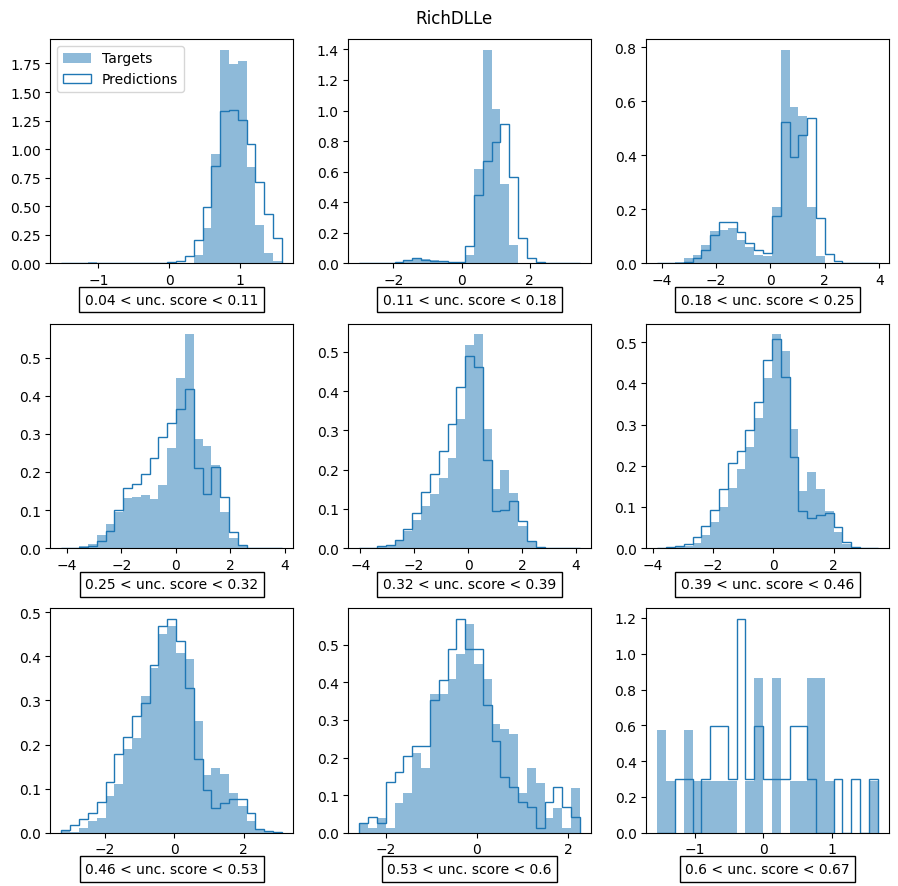

In [20]:
mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
    y_sample, t_generated, mcd_uncertainty, uncertainty_type = 'MCD', particle_index = 0)

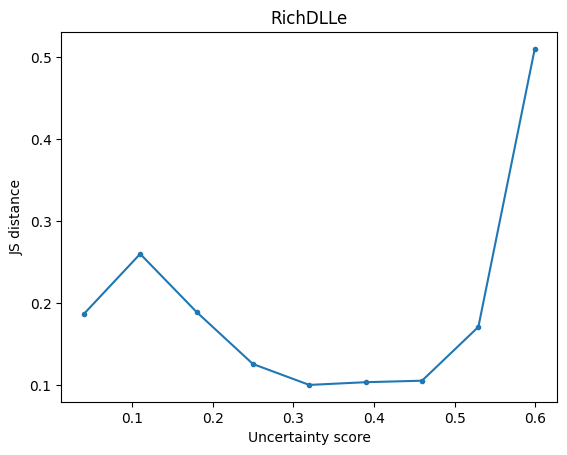

Correlation coefficient: 0.2945772901537031


In [27]:
plot_distances(mcd_bin_edges, mcd_js_distances)

## Feature Densities method

### Uncertainty estimation

In [13]:
from feature_densities.feature_density_evaluator import evaluate_model as fd_evaluate_model

train_embeddings = np.load(embeddings_dir + f'{PARTICLE}_train_embeddings.npy')
print(train_embeddings.shape)

(948325, 128)


In [14]:
fd_uncertainty_normalized, _ = fd_evaluate_model(model, x_sample, known_embeddings=train_embeddings, n_fit_samples=1000,
                                                 likelihood_method='normalized')

print('Feature Densities using NORMALIZED uncertainty score for x_sample:')
fd_uncertainty_normalized

Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 11s 3ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [04:16<00:00,  2.00s/it]


Feature Densities using NORMALIZED uncertainty score for x_sample:


<tf.Tensor: shape=(100000,), dtype=float64, numpy=
array([0.62721458, 0.43402793, 0.28884846, ..., 0.33571397, 0.62082024,
       0.6824947 ])>

In [29]:
# Save FD uncertainties normalized
np.save(output_dir + f'{PARTICLE}_fd_uncertainty_normalized.npy', fd_uncertainty_normalized)

Plot FD uncertainties

Jensen–Shannon divergence: 0.08373960901275677
Jensen–Shannon divergence: 0.05674885419358985
Jensen–Shannon divergence: 0.07386887136603926
Jensen–Shannon divergence: 0.08197625271471812
Jensen–Shannon divergence: 0.10389998912221941
Jensen–Shannon divergence: 0.1215040312471324
Jensen–Shannon divergence: 0.16473332204011623
Jensen–Shannon divergence: 0.2106920896037496
Jensen–Shannon divergence: 0.32061759685355173


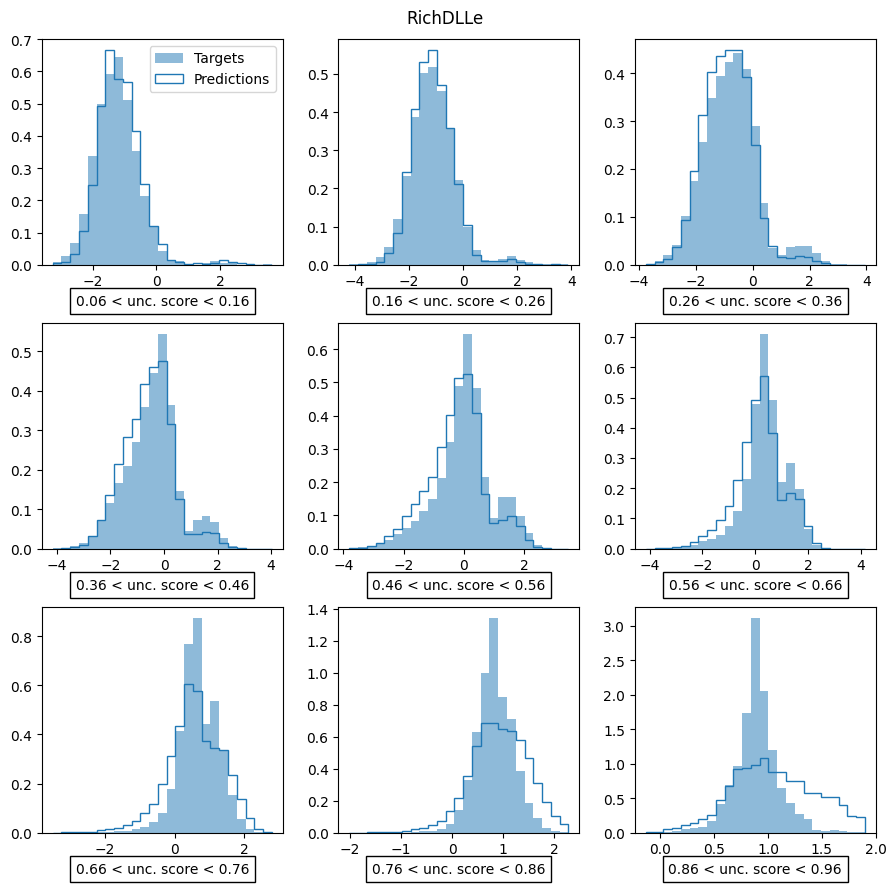

In [21]:
fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
    y_sample, t_generated, fd_uncertainty_normalized, particle_index = 0, n_rows = 3, n_cols = 3)

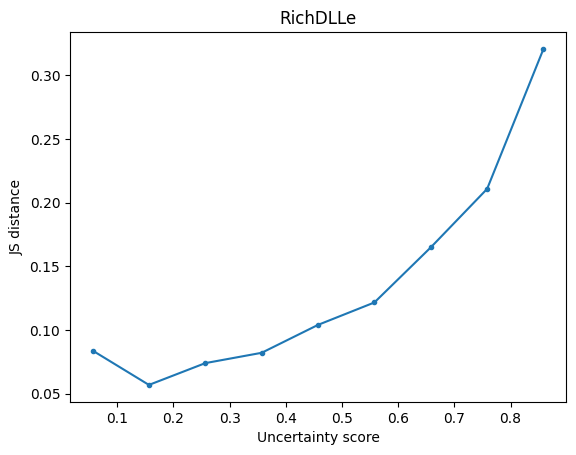

Correlation coefficient: 0.8777690050883685


In [28]:
plot_distances(fd_bin_edges, fd_js_distances)

#### FD with integration method


In [ ]:
# fd_uncertainty_integration, _ = fd_evaluate_model(model, x_sample, known_embeddings=train_embeddings, likelihood_method='integration')

# print('Feature Densities using INTEGRATION uncertainty score for x_sample:')
# fd_uncertainty_integration

(948325, 128)
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample´s embeddings
2/2 [==============================] - 0s 6ms/step
Estimating sample´s feature densities


100%|██████████| 52/52 [10:21<00:00, 11.95s/it]

Feature Densities using INTEGRATION uncertainty score for x_sample:


<tf.Tensor: shape=(52,), dtype=float64, numpy=
array([0.99696795, 0.98386122, 0.9930798 , 0.99029255, 0.99388116,
       0.99106039, 0.98962542, 0.99185572, 0.98346811, 0.99297008,
       0.99250436, 0.99122989, 0.99037003, 0.97890695, 0.99057272,
       0.99336079, 0.98162482, 0.9881128 , 0.98746889, 0.99346868,
       0.99161914, 0.98390812, 0.98245716, 0.98058026, 0.97937096,
       0.99569436, 0.98796848, 0.9909012 , 0.98491409, 0.99193857,
       0.98075132, 0.99061284, 0.99276764, 0.98459823, 0.98762967,
       0.9787404 , 0.98669493, 0.98364207, 0.98975249, 0.98866702,
       0.99224149, 0.9924707 , 0.99271423, 0.99475767, 0.99674197,
       0.99607984, 0.99230945, 0.98954991, 0.99243532, 0.99160392,
       0.98236469, 0.98252359])>

In [ ]:
# Save FD uncertainties with integration
# np.save(output_dir + f'{PARTICLE}_fd_uncertainty_integration.npy', fd_uncertainty_integration)

### Generation of FD embeddings

In [ ]:
# from feature_densities.feature_density_evaluator import create_embeddings_model
# embeddings_model = create_embeddings_model(model)

In [ ]:
# train_embeddings, train_predictions = embeddings_model.predict(dataset['feats_train'])

In [ ]:
# test_embeddings, test_predictions = embeddings_model.predict(dataset['feats_val'])

In [ ]:
# !rm -r embeddings
# !mkdir embeddings

# np.save(embeddings_dir + f'{PARTICLE}_train_embeddings.npy', train_embeddings)
# np.save(embeddings_dir + f'{PARTICLE}_train_predictions.npy', train_predictions)
# np.save(embeddings_dir + f'{PARTICLE}_test_embeddings.npy', test_embeddings)
# np.save(embeddings_dir + f'{PARTICLE}_test_predictions.npy', test_predictions)